In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

from imblearn.over_sampling import SMOTE 

from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, recall_score

In [2]:
df = pd.read_csv('D:/Dataset/HouseRentPrediction/House_Rent_Dataset.csv')
df.head()

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4746 entries, 0 to 4745
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Posted On          4746 non-null   object
 1   BHK                4746 non-null   int64 
 2   Rent               4746 non-null   int64 
 3   Size               4746 non-null   int64 
 4   Floor              4746 non-null   object
 5   Area Type          4746 non-null   object
 6   Area Locality      4746 non-null   object
 7   City               4746 non-null   object
 8   Furnishing Status  4746 non-null   object
 9   Tenant Preferred   4746 non-null   object
 10  Bathroom           4746 non-null   int64 
 11  Point of Contact   4746 non-null   object
dtypes: int64(4), object(8)
memory usage: 445.1+ KB


### Data Cleaning

In [4]:
# Check missing value
df.isna().sum()

Posted On            0
BHK                  0
Rent                 0
Size                 0
Floor                0
Area Type            0
Area Locality        0
City                 0
Furnishing Status    0
Tenant Preferred     0
Bathroom             0
Point of Contact     0
dtype: int64

In [5]:
# Check duplicated value
df.duplicated().sum()

0

### Exploratory Data Analysis

#### Statistical summary

In [6]:
nums = ['Rent','Size']
df[nums].describe()

,Rent,Size
count,4.746000e+03,4746.000000
mean,3.499345e+04,967.490729
std,7.810641e+04,634.202328
min,1.200000e+03,10.000000
25%,1.000000e+04,550.000000
50%,1.600000e+04,850.000000
75%,3.300000e+04,1200.000000
max,3.500000e+06,8000.000000


From statistical summary we can see that Size, and Bathroom are positively skewed while Rent is negatively skewed. We will check the distribution plot to make sure of it.

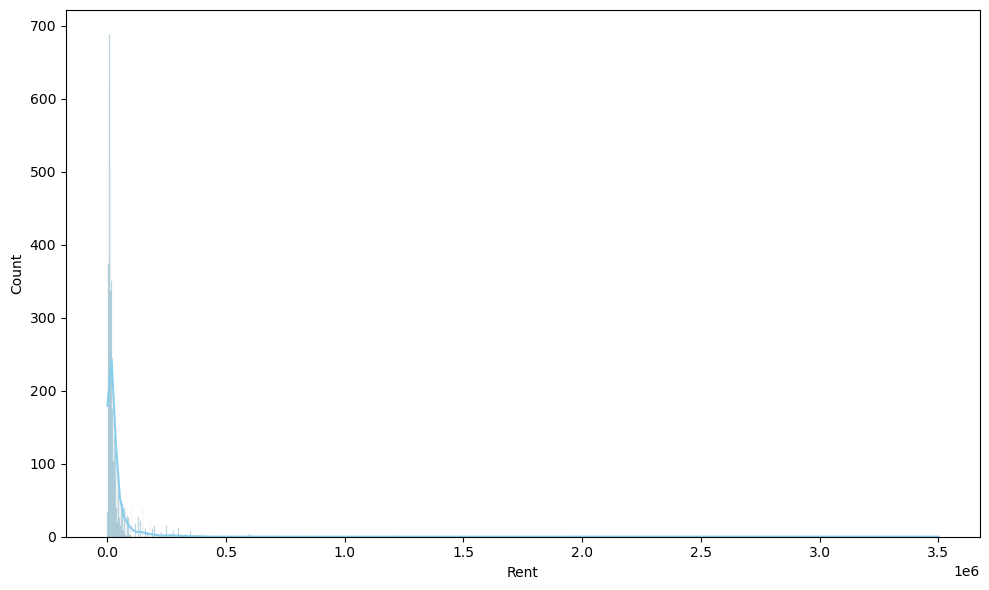

In [7]:
# Checking distribution of Rent
plt.figure(figsize=(10,6))
sns.histplot(x=df['Rent'], color = 'skyblue', kde=True)
plt.xlabel('Rent')
plt.tight_layout()
plt.show()

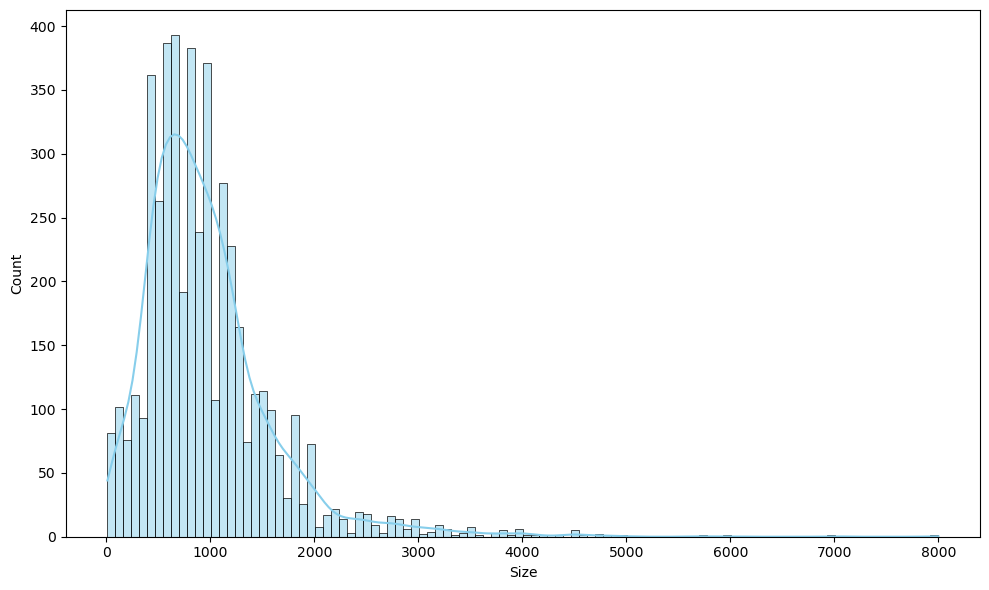

In [8]:
# Checking distribution of Rent
plt.figure(figsize=(10,6))
sns.histplot(x=df['Size'], color = 'skyblue', kde=True)
plt.xlabel('Size')
plt.tight_layout()
plt.show()

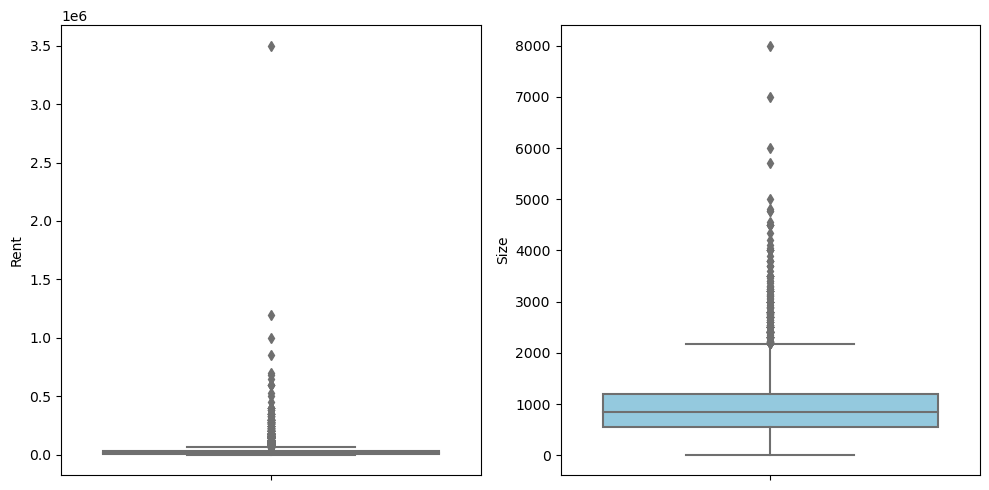

In [9]:
# Checking outlier for numerical data
plt.figure(figsize=(10,5))
for i in range(0, len (nums)):
  plt.subplot(1, len(nums), i+1) 
  sns.boxplot(y=df[nums[i]], color='skyblue') 
  plt.tight_layout()

As we can see there are many outliers for Rent and Size

<AxesSubplot:xlabel='City', ylabel='Rent'>

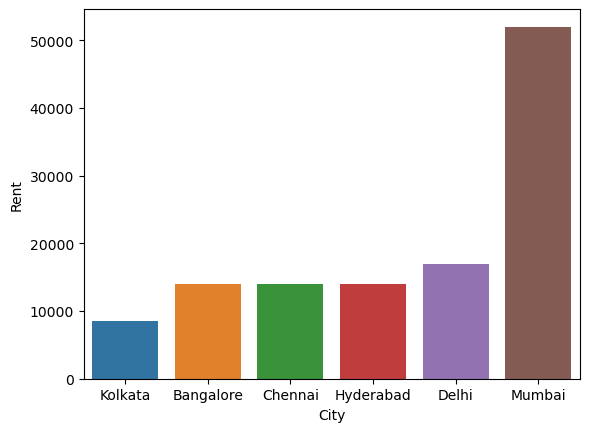

In [15]:
df_rent_city = pd.DataFrame(df.groupby(['City'])['Rent'].median().reset_index())
sns.barplot(data=df_rent_city.sort_values(by='Rent', ascending=True), x='City', y='Rent')

We got some insight that Mumbai is the city with highest rent.

<AxesSubplot:xlabel='City', ylabel='Count'>

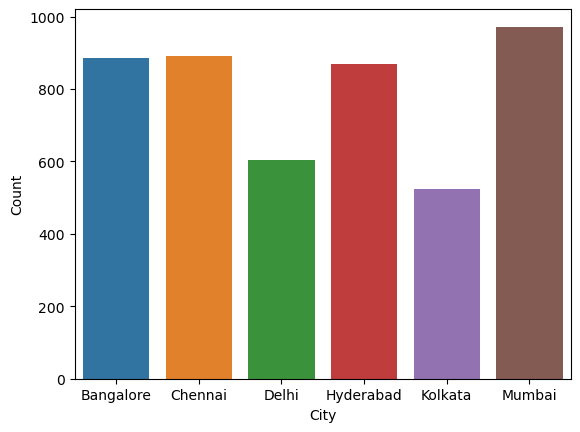

In [10]:
# Check which city has the most rented house
df_city = pd.DataFrame(df.groupby(['City']).size().reset_index())
df_city = df_city.rename(columns={0:'Count'})
sns.barplot(data=df_city, x='City', y='Count')

The highest rented house is in Mumbai

<AxesSubplot:xlabel='City', ylabel='Count'>

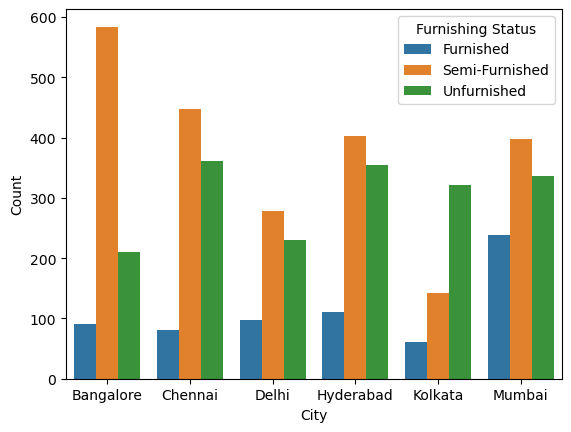

In [11]:
# Check which furniture status of house rented the most
df_furniture = pd.DataFrame(df.groupby(['Furnishing Status','City']).size().reset_index())
df_furniture = df_furniture.rename(columns={0:'Count'})
sns.barplot(data=df_furniture, x='City', y='Count', hue='Furnishing Status')

Houses with semi-furnished is the most rented compared to the others in each cities.

In [12]:
df_Type=pd.DataFrame(df.groupby(['Area Type'])['Rent'].mean().reset_index())

<AxesSubplot:xlabel='Area Type', ylabel='Rent'>

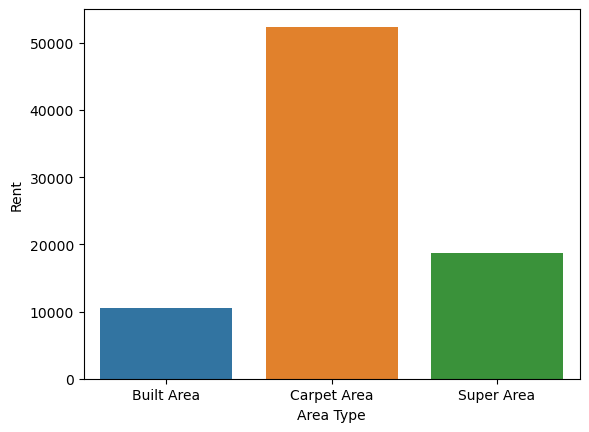

In [13]:
sns.barplot(data=df_Type, x='Area Type', y='Rent')

There is a pattern that the rent is increasing up until 5 BHK. The houses with 6 BHK have lower rent 5 BHK. It can be out of the city or it is not as big as 5 BHK houses.

<AxesSubplot:xlabel='BHK', ylabel='Rent'>

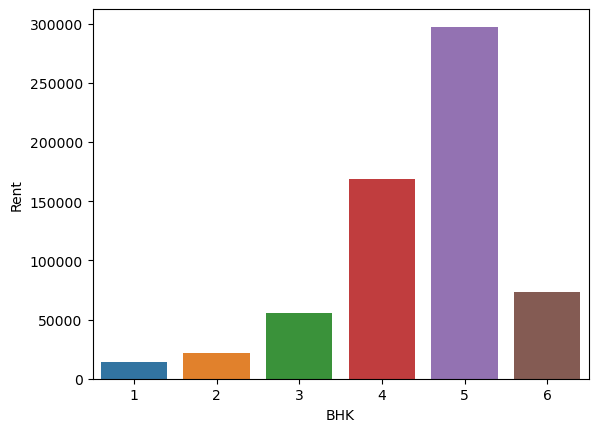

In [14]:
df_BHK_Type=pd.DataFrame(df.groupby(['BHK'])['Rent'].mean().reset_index())
sns.barplot(data=df_BHK_Type, x='BHK', y='Rent')

In [16]:
df_BHK_City = pd.DataFrame(df.groupby(['BHK','City']).size().reset_index())
df_BHK_City = df_BHK_City.rename(columns={0:'Count'})

<AxesSubplot:xlabel='BHK', ylabel='Count'>

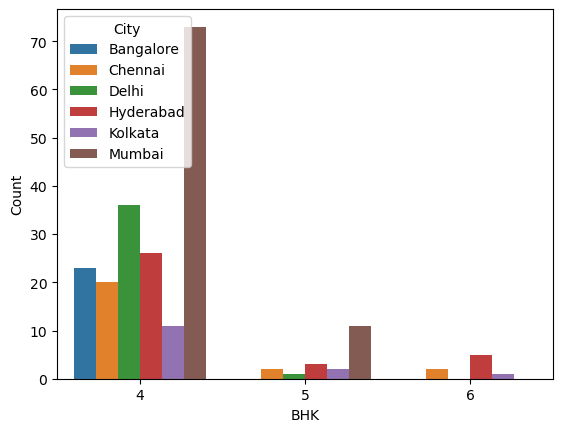

In [17]:
df_BHK_City = df_BHK_City[df_BHK_City['BHK']>3]
sns.barplot(x=df_BHK_City['BHK'], y=df_BHK_City['Count'], hue=df_BHK_City['City'])

Now we know the reason why houses with 6 rooms have lower rent than houses with 5 rooms. The reason is the location of those houses is outside of main cities like Mumbai, New Delhi, or Bangalore

##### Drop some unused columns

In [18]:
df.drop(["Posted On"], axis="columns", inplace=True)
df.drop(["Area Locality"], axis="columns", inplace=True)

#### Data preprocessing

##### Handling categorical variable

In [19]:
# Check how many unique value in each categorical variable
df_object = df.select_dtypes(include='object')
for i in df_object.columns:
    print(i,'has',df[i].nunique(),'unique value(s)')

Floor has 480 unique value(s)
Area Type has 3 unique value(s)
City has 6 unique value(s)
Furnishing Status has 3 unique value(s)
Tenant Preferred has 3 unique value(s)
Point of Contact has 3 unique value(s)


Floor has so many unique values. Let's check what is the value of 'Floor'

In [20]:
df['Floor'].head()

0    Ground out of 2
1         1 out of 3
2         1 out of 3
3         1 out of 2
4         1 out of 2
Name: Floor, dtype: object

We will do feature engineering where we create new features which are 'Floor Number' and 'Total Floor'. So instead of floor 1 out of 3 we will see 1 as 'Floor Number' and 3 as 'Total Floor'

In [21]:
df["Floor Number"]=df["Floor"].apply(lambda x:str(x).split()[0])
df["Total Floor"]=df["Floor"].apply(lambda x:str(x).split()[-1])

In [22]:
df["Total Floor"].value_counts()

4         938
3         915
2         868
5         422
1         335
         ... 
39          1
62          1
59          1
66          1
Ground      1
Name: Total Floor, Length: 67, dtype: int64

In [23]:
# Change 'Ground' to 0, 'Lower' to -2, and 'Upper' to -1
df['Floor Number'] = df['Floor Number'].replace(['Ground'],0)
df['Floor Number'] = df['Floor Number'].replace(['Lower'],-2)
df['Floor Number'] = df['Floor Number'].replace(['Upper'],-1)
df['Total Floor'] = df['Total Floor'].replace(['Ground'],0)
df.drop(["Floor"], axis="columns", inplace=True)


In [24]:
df['Floor Number']=df['Floor Number'].astype(int)
df['Total Floor']=df['Total Floor'].astype(int)

In [25]:
#label_encoder = preprocessing.LabelEncoder()
  
# Encode labels in column "Area Type".
#df["Area Type"]= label_encoder.fit_transform(df["Area Type"])
# Encode labels in column "Furnishing Status".
#df["Furnishing Status"]= label_encoder.fit_transform(df["Furnishing Status"])
# Encode labels in column "Tenant Preferred".
#df["Tenant Preferred"]= label_encoder.fit_transform(df["Tenant Preferred"])
# Encode labels in column "Area Type".
#df["Point of Contact"]= label_encoder.fit_transform(df["Point of Contact"])
# Encode labels in column "City".
#df['City']= label_encoder.fit_transform(df['City'])

In [26]:
#min-max scale
from sklearn.preprocessing import minmax_scale

df["Rent"] = minmax_scale(df["Rent"])

In [27]:
from sklearn.preprocessing import minmax_scale

df["Size"] = minmax_scale(df["Size"])

In [28]:
#Data Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
#Importing Models
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [29]:
# One hot encoding
df =pd.get_dummies(data=df, columns=['Area Type','City', 'Furnishing Status', 'Tenant Preferred',
      'Point of Contact'], drop_first=True)
df.head()

,BHK,Rent,Size,Bathroom,Floor Number,Total Floor,Area Type_Carpet Area,Area Type_Super Area,City_Chennai,City_Delhi,City_Hyderabad,City_Kolkata,City_Mumbai,Furnishing Status_Semi-Furnished,Furnishing Status_Unfurnished,Tenant Preferred_Bachelors/Family,Tenant Preferred_Family,Point of Contact_Contact Builder,Point of Contact_Contact Owner
0,2,0.002515,0.136421,2,0,2,0,1,0,0,0,1,0,0,1,1,0,0,1
1,2,0.005373,0.098874,1,1,3,0,1,0,0,0,1,0,1,0,1,0,0,1
2,2,0.004516,0.123905,1,1,3,0,1,0,0,0,1,0,1,0,1,0,0,1
3,2,0.002515,0.098874,1,1,2,0,1,0,0,0,1,0,0,1,1,0,0,1
4,2,0.001801,0.105131,1,1,2,1,0,0,0,0,1,0,0,1,0,0,0,1


In [30]:
X=df.drop('Rent',axis=1)
y=df['Rent']
# Train-Test Split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [31]:
# calculate VIF scores
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif 
from statsmodels.tools.tools import add_constant

X = add_constant(X_train)

vif_df = pd.DataFrame([vif(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns).reset_index()
vif_df.columns = ['feature','vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

,feature,vif_score
1,BHK,3.228045
2,Size,2.832338
3,Bathroom,3.984709
4,Floor Number,3.732245
5,Total Floor,4.348203
6,Area Type_Carpet Area,476.463235
7,Area Type_Super Area,475.434237
8,City_Chennai,1.667431
9,City_Delhi,1.597350
10,City_Hyderabad,1.675169


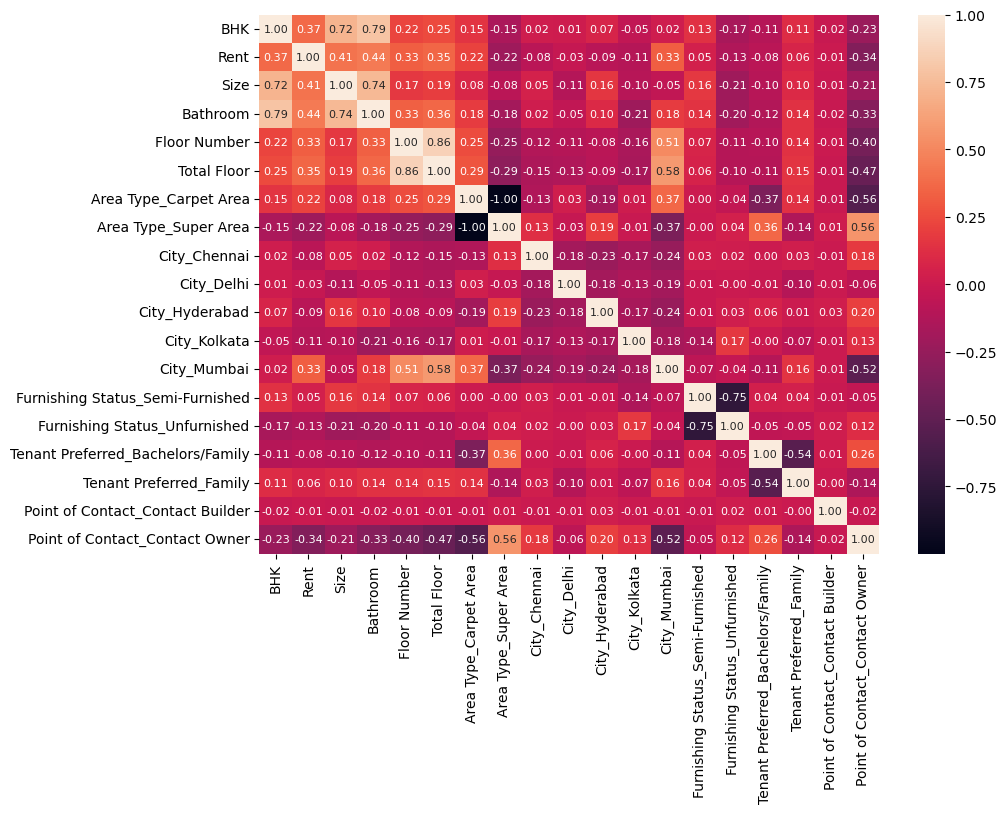

In [32]:
# Check correlation
df_corr = pd.concat([X_train, y_train], axis=1)
corr = df.corr()

plt.figure(figsize=(10,7))
ax=sns.heatmap(corr, annot=True, fmt='.2f', annot_kws={"fontsize":8})
plt.show()

In [33]:
X_train = X_train.drop(columns=['Total Floor','Area Type_Super Area'])
X_test = X_test.drop(columns=['Total Floor','Area Type_Super Area'])

In [34]:
# calculate VIF scores
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif 
from statsmodels.tools.tools import add_constant

X = add_constant(X_train)

vif_df = pd.DataFrame([vif(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns).reset_index()
vif_df.columns = ['feature','vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

,feature,vif_score
1,BHK,3.223318
2,Size,2.831637
3,Bathroom,3.976755
4,Floor Number,1.483774
5,Area Type_Carpet Area,1.642664
6,City_Chennai,1.665561
7,City_Delhi,1.594379
8,City_Hyderabad,1.674487
9,City_Kolkata,1.529141
10,City_Mumbai,2.562825


In [35]:
ss=StandardScaler()
X_train=ss.fit_transform(X_train)
X_test=ss.transform(X_test)
pd.DataFrame(X_train)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-0.107739,-0.026920,0.035666,0.475031,-0.967851,-0.482564,-0.384536,-0.468404,-0.346069,-0.505674,1.052482,-0.789250,0.614295,-0.330104,-0.016233,0.689435
1,-0.107739,-0.263117,0.035666,-0.066422,-0.967851,-0.482564,-0.384536,-0.468404,-0.346069,-0.505674,1.052482,-0.789250,0.614295,-0.330104,-0.016233,0.689435
2,-1.300098,-0.664654,-1.092556,-0.246906,-0.967851,-0.482564,2.600535,-0.468404,-0.346069,-0.505674,-0.950135,-0.789250,0.614295,-0.330104,-0.016233,0.689435
3,-1.300098,-0.790626,-1.092556,-0.066422,-0.967851,-0.482564,-0.384536,-0.468404,-0.346069,1.977558,1.052482,-0.789250,-1.627882,-0.330104,-0.016233,0.689435
4,-0.107739,-0.105652,0.035666,0.114063,-0.967851,-0.482564,-0.384536,-0.468404,-0.346069,-0.505674,-0.950135,-0.789250,0.614295,-0.330104,-0.016233,0.689435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3791,1.084619,0.839139,1.163887,-0.427390,1.033217,-0.482564,-0.384536,2.134908,-0.346069,-0.505674,1.052482,-0.789250,-1.627882,3.029347,-0.016233,0.689435
3792,1.084619,0.366743,0.035666,-0.066422,-0.967851,-0.482564,-0.384536,-0.468404,2.889594,-0.505674,-0.950135,1.267025,0.614295,-0.330104,-0.016233,0.689435
3793,-0.107739,-0.263117,0.035666,1.738419,1.033217,2.072265,-0.384536,-0.468404,-0.346069,-0.505674,1.052482,-0.789250,-1.627882,3.029347,-0.016233,-1.450463
3794,1.084619,3.988442,1.163887,-0.607874,1.033217,2.072265,-0.384536,-0.468404,-0.346069,-0.505674,1.052482,-0.789250,0.614295,-0.330104,-0.016233,-1.450463


In [36]:
models = {
    'Linear' : LinearRegression(),
    'ridge' : Ridge(),
    'lasso' : Lasso(),
    'random forest' : RandomForestRegressor(),
    'knn' : KNeighborsRegressor(n_neighbors = 4)
}

In [37]:
for name, model in models.items():
    model.fit(X_train, y_train)
    print(f'{name} trained')

Linear trained
ridge trained
lasso trained
random forest trained
knn trained


In [38]:
for name, model in models.items():
    y_pred = model.predict(X_train)
    print('RMSE for',name, 'is:',round(np.sqrt(mean_squared_error(y_train, y_pred)),3))

RMSE for Linear is: 0.02
RMSE for ridge is: 0.02
RMSE for lasso is: 0.023
RMSE for random forest is: 0.009
RMSE for knn is: 0.017


In [39]:
for name, model in models.items():
    y_test_pred = model.predict(X_test)
    print('RMSE for',name, 'is:',round(np.sqrt(mean_squared_error(y_test, y_test_pred)),3))

RMSE for Linear is: 0.012
RMSE for ridge is: 0.012
RMSE for lasso is: 0.018
RMSE for random forest is: 0.01
RMSE for knn is: 0.016


In [42]:
# Set the input and output sizes
input_size = 16
output_size = 1
hidden_layer_size = 50
    
 
model = tf.keras.Sequential([
    tf.keras.layers.Dense(hidden_layer_size, activation='relu', input_dim = input_size), 
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'),     
    tf.keras.layers.Dense(output_size, activation='linear')
])
 
 
model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.RootMeanSquaredError()])
 
batch_size = 100
max_epochs = 100
early_stopping = tf.keras.callbacks.EarlyStopping(patience=2)
 
history=model.fit(X_train, y_train, 
          batch_size=batch_size,
          epochs=max_epochs,
          validation_split=0.2,
          verbose = 2, 
          )  

Epoch 1/100
31/31 - 1s - loss: 0.0294 - root_mean_squared_error: 0.1713 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1154 - 945ms/epoch - 30ms/step
Epoch 2/100
31/31 - 0s - loss: 0.0071 - root_mean_squared_error: 0.0840 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0900 - 289ms/epoch - 9ms/step
Epoch 3/100
31/31 - 0s - loss: 0.0042 - root_mean_squared_error: 0.0648 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0818 - 203ms/epoch - 7ms/step
Epoch 4/100
31/31 - 0s - loss: 0.0030 - root_mean_squared_error: 0.0549 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0685 - 124ms/epoch - 4ms/step
Epoch 5/100
31/31 - 0s - loss: 0.0023 - root_mean_squared_error: 0.0481 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0627 - 110ms/epoch - 4ms/step
Epoch 6/100
31/31 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0436 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0563 - 87ms/epoch - 3ms/step
Epoch 7/100
31/31 - 0s - loss: 0.0016 - root_mean_squared_error: 0.0398 - va

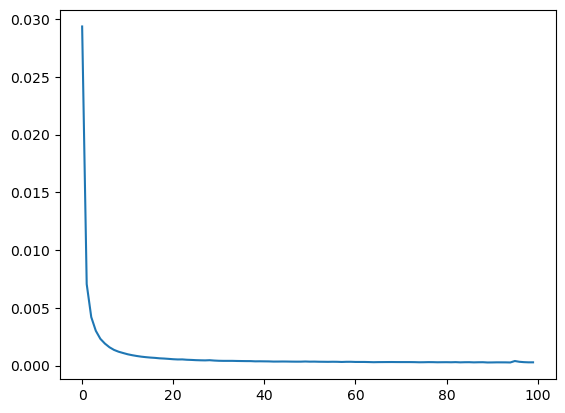

In [43]:
# convert the training history to a dataframe
history_df = pd.DataFrame(history.history)
# use Pandas native plot method
history_df['loss'].plot();

In [44]:
test_loss, MSE = model.evaluate(X_test, y_test)
print(MSE)

30/30 [==============================] - 0s 2ms/step - loss: 4.3389e-04 - root_mean_squared_error: 0.0208
0.020830074325203896
